In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import pickle as pkl
from collections import Counter

import statistics as s
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning


In [2]:
#import pre-processed data
fc_IC_regression = pd.read_csv('fc_IC_regression.csv')
fc_accent_regression = pd.read_csv('fc_accent_regression.csv')

In [3]:
#UTILS FOR PLOTTING RESULTS
def plot_coefs(model, labels = 'auto', palette='viridis', colors = None):
    coefficients = model.params.tolist()
    std_errors = model.bse.tolist()

    if labels == 'auto':
        predictors = model.params.index.tolist()
       
    else:
        predictors = labels

    ci_lower = [coef - 1.96 * se for coef, se in zip(coefficients, std_errors)]
    ci_upper = [coef + 1.96 * se for coef, se in zip(coefficients, std_errors)]

    data = pd.DataFrame({
    'Predictor': predictors,
    'Coefficient': coefficients,
    'Std. Error': std_errors,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
    })

    if colors is not None and len(colors) == len(predictors):
        palette = colors
    else:
        palette = sns.color_palette('Blues_d', len(predictors))

    yerr = data['CI Upper'] - data['CI Lower']
    yerr_lower = data['Coefficient'] - data['CI Lower']
    yerr_upper = data['CI Upper'] - data['Coefficient']


    plt.figure(figsize=(10, 6))
    sns.barplot(x='Predictor', y='Coefficient', data=data, palette=palette)
    #plt.errorbar(x=data['Predictor'], y=data['Coefficient'], yerr=data['Std. Error'], fmt='o', color='black')
    plt.errorbar(x=data['Predictor'], y=data['Coefficient'], 
             yerr=[yerr_lower, yerr_upper], fmt='o', color='black', capsize=5)

    plt.xlabel('Predictor')
    plt.ylabel('Coefficient')
    plt.hlines(0, -0.5, len(predictors), color = 'black')
    plt.tight_layout()
    plt.show()

    


### Mixed effects model for accent forced choice

In [4]:
#considering only the effects of IC and contour
md_accent = smf.mixedlm("accent_chosen ~ IC + C(contour)", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_accent = md_accent.fit(method=["lbfgs"])
print(mdf_accent.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  accent_chosen
No. Observations:  1248     Method:              REML         
No. Groups:        78       Scale:               0.1837       
Min. group size:   16       Log-Likelihood:      -794.2109    
Max. group size:   16       Converged:           Yes          
Mean group size:   16.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.393    0.039 10.084 0.000  0.316  0.469
C(contour)[T.asc]    0.015    0.042  0.369 0.712 -0.066  0.097
C(contour)[T.des]    0.005    0.047  0.107 0.915 -0.088  0.098
C(contour)[T.inv-U]  0.098    0.029  3.416 0.001  0.042  0.154
IC                  -0.035    0.031 -1.123 0.261 -0.095  0.026
Group Var            0.059    0.027                           



/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_19907/4131296526.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predictor', y='Coefficient', data=data, palette=palette)


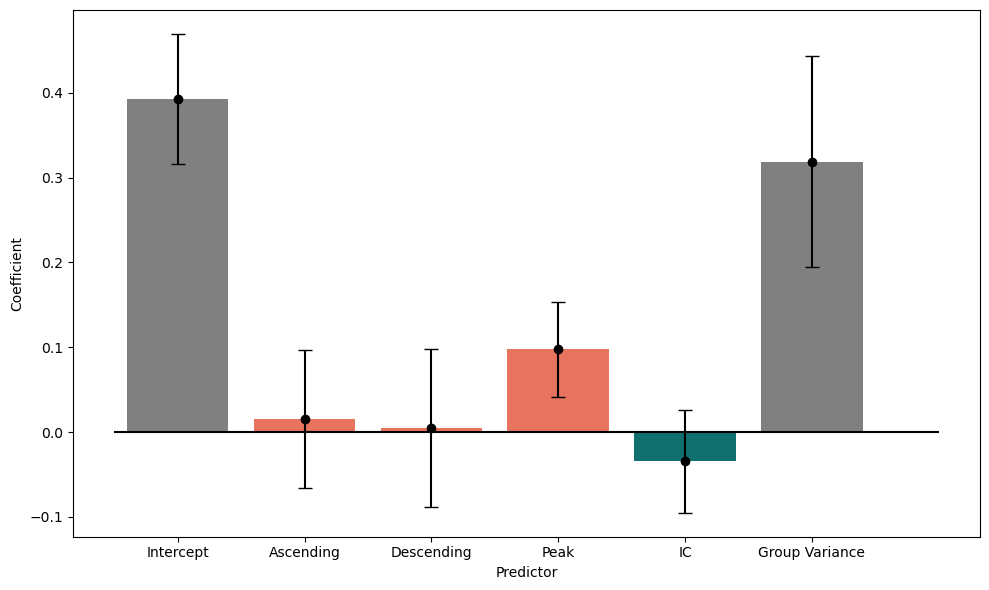

In [5]:
#plot_coefs(mdf_accent, labels = 'auto')
plot_coefs(mdf_accent, 
           labels = ['Intercept', 'Ascending', 'Descending', 'Peak', 'IC', 'Group Variance'], 
           colors = ['Grey', 'Tomato', 'Tomato', 'Tomato', 'Teal', 'Gray'])


In [6]:
#considering the effects of IC, contour, musicianship, and interaction between musicianship and contour
md_accent_mus = smf.mixedlm("accent_chosen ~ IC + C(musician) + C(contour) + IC:C(musician)", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_accent_mus = md_accent_mus.fit(method=["lbfgs"])
print(mdf_accent_mus.summary())

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  accent_chosen
No. Observations:  1248     Method:              REML         
No. Groups:        78       Scale:               0.1839       
Min. group size:   16       Log-Likelihood:      -797.6240    
Max. group size:   16       Converged:           Yes          
Mean group size:   16.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.389    0.043  9.026 0.000  0.304  0.473
C(musician)[T.1]     0.019    0.077  0.249 0.804 -0.132  0.170
C(contour)[T.asc]    0.015    0.042  0.366 0.714 -0.066  0.097
C(contour)[T.des]    0.005    0.047  0.100 0.921 -0.088  0.098
C(contour)[T.inv-U]  0.098    0.029  3.412 0.001  0.042  0.154
IC                  -0.042    0.034 -1.233 0.218 -0.108  0.024
IC:C(

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_19907/4131296526.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predictor', y='Coefficient', data=data, palette=palette)


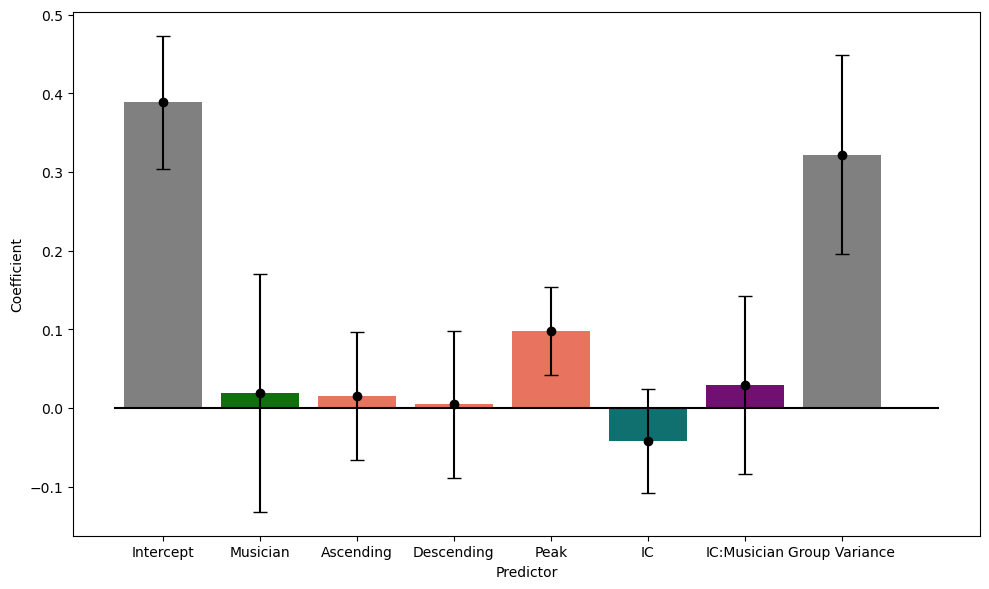

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plot_coefs(mdf_accent_mus, 
           #labels='auto',
           labels = ['Intercept', 'Musician', 'Ascending', 'Descending', 'Peak', 'IC', 'IC:Musician', 'Group Variance'], 
           colors = ['Grey', 'Green', 'Tomato', 'Tomato', 'Tomato', 'Teal', 'Purple', 'Gray']
           )

plt.savefig('./figures/me_accent.png', dpi = 200)

In [8]:
md_tonic = smf.mixedlm("accent_chosen ~ IC:C(condition)", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_tonic = md_tonic.fit(method=["lbfgs"])
print(mdf_tonic.summary())

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    accent_chosen
No. Observations:     1248       Method:                REML         
No. Groups:           78         Scale:                 0.1851       
Min. group size:      16         Log-Likelihood:        -798.3517    
Max. group size:      16         Converged:             Yes          
Mean group size:      16.0                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.417    0.032 13.008 0.000  0.354  0.479
IC:C(condition)[tonic A4]  -0.122    0.058 -2.097 0.036 -0.236 -0.008
IC:C(condition)[tonic Bb4]  0.010    0.058  0.179 0.858 -0.104  0.124
IC:C(condition)[tonic C5]   0.041    0.058  0.695 0.487 -0.074  0.155
IC:C(condition)[tonic Cs5] -0.045   

In [9]:
md_tonic = smf.mixedlm("accent_chosen ~ IC + C(contour) + C(condition)", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_tonic = md_tonic.fit(method=["lbfgs"])
print(mdf_tonic.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    accent_chosen
No. Observations:    1248       Method:                REML         
No. Groups:          78         Scale:                 0.1837       
Min. group size:     16         Log-Likelihood:        -797.9043    
Max. group size:     16         Converged:             Yes          
Mean group size:     16.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.344    0.078  4.415 0.000  0.191  0.497
C(contour)[T.asc]          0.011    0.042  0.262 0.794 -0.071  0.093
C(contour)[T.des]          0.005    0.048  0.097 0.923 -0.089  0.098
C(contour)[T.inv-U]        0.100    0.029  3.481 0.000  0.044  0.156
C(condition)[T.tonic Bb4]  0.051    0.106  0.485 0

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


### Mixed effects model for IC forced choice

In [10]:
#considering only the effect of accent
md_IC = smf.mixedlm("high_IC_chosen ~ accent", fc_IC_regression, groups=fc_IC_regression['subject'] )
mdf_IC = md_IC.fit(method=["lbfgs"])
print(mdf_IC.summary())

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: high_IC_chosen
No. Observations: 1248    Method:             REML          
No. Groups:       78      Scale:              0.2380        
Min. group size:  16      Log-Likelihood:     -903.4563     
Max. group size:  16      Converged:          Yes           
Mean group size:  16.0                                      
-------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.484     0.023  20.814  0.000   0.438   0.530
accent         0.013     0.028   0.464  0.642  -0.041   0.067
Group Var      0.012     0.009                               



In [11]:
md_IC = smf.mixedlm("high_IC_chosen ~ accent + C(musician) + accent:C(musician)", fc_IC_regression, groups=fc_IC_regression['subject'] )
mdf_IC = md_IC.fit(method=["lbfgs"])
print(mdf_IC.summary())

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  high_IC_chosen
No. Observations:    1248     Method:              REML          
No. Groups:          78       Scale:               0.2382        
Min. group size:     16       Log-Likelihood:      -907.1326     
Max. group size:     16       Converged:           Yes           
Mean group size:     16.0                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.477    0.027 17.964 0.000  0.425  0.529
C(musician)[T.1]        0.030    0.055  0.540 0.589 -0.078  0.138
accent                  0.010    0.032  0.331 0.741 -0.051  0.072
accent:C(musician)[T.1] 0.010    0.066  0.159 0.874 -0.118  0.139
Group Var               0.013    0.009                           



/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_19907/4131296526.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Predictor', y='Coefficient', data=data, palette=palette)


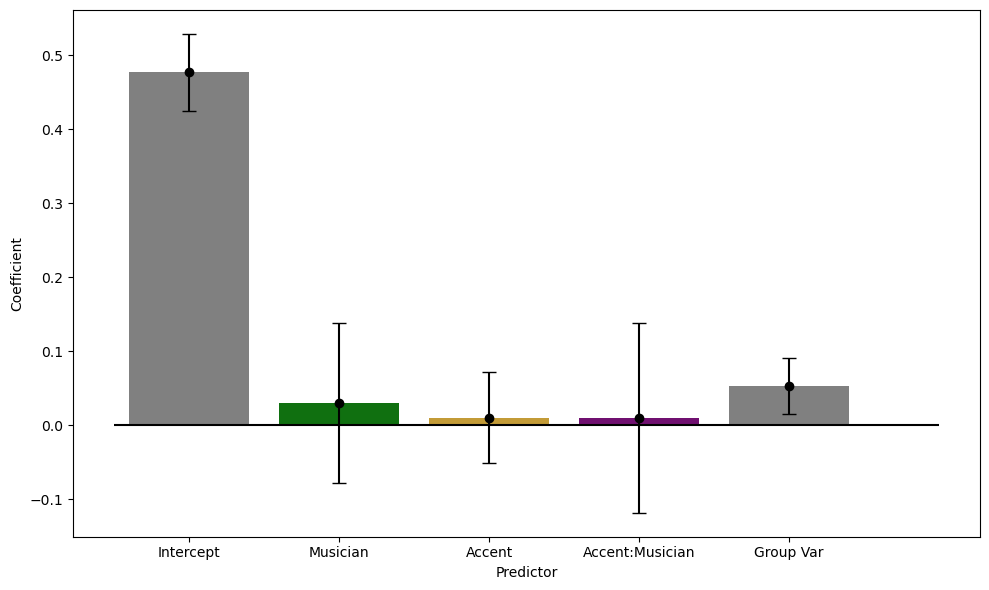

In [12]:
plot_coefs(mdf_IC,
           labels=['Intercept', 'Musician', 'Accent', 'Accent:Musician', 'Group Var'],
           colors= ['Grey', 'Green', 'Goldenrod', 'Purple', 'Grey'])

,subject,condition,filename,sequence,accent_chosen,IC,target_pos,invU,U,asc,des,target_metric_2,target_metric_4,contour,musician
0,dykydm,tonic Cs5,fc_accents_32_4.mp3,"[1, 2, 6, 3, 2, 3, 1]",1,1.0,4,0,1,0,0,1,1,U,0
1,dykydm,tonic Cs5,fc_accents_34_1.mp3,"[1, 2, 6, 3, 4, 5, 3, 1]",1,0.0,4,0,0,1,0,1,1,asc,0
2,dykydm,tonic Cs5,fc_accents_54_2.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",0,0.0,4,0,1,0,0,1,1,U,0
3,dykydm,tonic Cs5,fc_accents_56_2.mp3,"[1, 2, 6, 5, 6, 5, 3, 1]",0,1.0,4,1,0,0,0,1,1,inv-U,0
4,dykydm,tonic Cs5,fc_accents_56_4.mp3,"[1, 2, 6, 5, 6, 5, 3, 1]",0,1.0,4,1,0,0,0,1,1,inv-U,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,mesgdu,tonic E5,fc_accents_34_1.mp3,"[1, 2, 6, 3, 4, 5, 3, 1]",0,0.0,4,0,0,1,0,1,1,asc,0
1244,mesgdu,tonic E5,fc_accents_32_2.mp3,"[1, 2, 6, 3, 2, 3, 1]",0,1.0,4,0,1,0,0,1,1,U,0
1245,mesgdu,tonic E5,fc_accents_56_2.mp3,"[1, 2, 6, 5, 6, 3, 1]",0,1.0,4,1,0,0,0,1,1,inv-U,0
1246,mesgdu,tonic E5,fc_accents_56_1.mp3,"[1, 2, 6, 5, 6, 5, 3, 1]",0,1.0,4,1,0,0,0,1,1,inv-U,0


In [14]:
md_accent_mus = smf.mixedlm("accent_chosen ~ IC + C(musician) + C(contour) + IC:C(musician)", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_accent_mus = md_accent_mus.fit(method=["lbfgs"])
print(mdf_accent_mus.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  accent_chosen
No. Observations:  1248     Method:              REML         
No. Groups:        78       Scale:               0.1839       
Min. group size:   16       Log-Likelihood:      -797.6240    
Max. group size:   16       Converged:           Yes          
Mean group size:   16.0                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.389    0.043  9.026 0.000  0.304  0.473
C(musician)[T.1]     0.019    0.077  0.249 0.804 -0.132  0.170
C(contour)[T.asc]    0.015    0.042  0.366 0.714 -0.066  0.097
C(contour)[T.des]    0.005    0.047  0.100 0.921 -0.088  0.098
C(contour)[T.inv-U]  0.098    0.029  3.412 0.001  0.042  0.154
IC                  -0.042    0.034 -1.233 0.218 -0.108  0.024
IC:C(

/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


### Additional analyses

Did any melodies receive high ratings independent of grammaticality?

In [15]:
df_learning = pd.read_csv('grammar_learning.csv')

In [28]:
md_grammar = smf.mixedlm("response ~ grammaticality", df_learning, groups=df_learning['filename'])
mdf_grammar = md_grammar.fit(method=["lbfgs"])
print(mdf_grammar.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      response  
No. Observations:      1248         Method:                  REML      
No. Groups:            16           Scale:                   2.2407    
Min. group size:       78           Log-Likelihood:          -2281.4596
Max. group size:       78           Converged:               Yes       
Mean group size:       78.0                                            
-----------------------------------------------------------------------
                              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     4.066    0.082 49.568 0.000  3.905  4.226
grammaticality[T.grammatical] 1.540    0.116 13.277 0.000  1.313  1.767
Group Var                     0.025    0.014                           



/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
